In [1]:
import matplotlib.pyplot as plt
import paraview.simple as pvs
import pandas as pd
import math
from pathlib import Path


# Biocellion Output Plotting
This notebook defines functions to read and plot the biocellion output data for the Biocellion ABM models by the CMMC that can be found in github.com/TheCMMC. For more information on the CMMC, visit www.thecmmc.org.  

To use these plotting functions the biocellion output summary should be in one directory with the following naming pattern:
`output_parameter{par_id}_trial{trial}.txt`

If the scripts and instructions in https://github.com/TheCMMC/biocellion-tools have been used to create the output, this notebook should be able to run with the resulting data.

## User settings

In [2]:
# Set this data folder to the place where you cloned the repository https://github.com/TheCMMC/biocellion-data
DATA_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-data")
MODEL_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user")
FIG_FOLDER = Path("./figures")

## Plotting functions

In [3]:
ABM_ONLY_DATA_FOLDER = DATA_FOLDER / "PLOSone_ABM-only-microcarrier"
ABM_ONLY_MODEL_FOLDER = MODEL_FOLDER / "ABM-only-microcarriers"

ABM_CFD_DATA_FOLDER = DATA_FOLDER / "PLOSone_ABM-CFD-microcarrier"
ABM_CFD_MODEL_FOLDER = MODEL_FOLDER / "ABM-microcarriers"

In [14]:
color_dict={'live': '#1f77b4', 'attached': '#2ca02c', 'dead': '#ff7f0e', 'removed': '#d62728'}

In [33]:
def read_parameter_file(filename):
    par_df = pd.read_csv(filename, index_col=0, header=2, skiprows=range(3,9), usecols=(lambda x: x not in str(list(range(11)))))
    return par_df
    
def read_summary_file(par_id, trial, data_folder):
    filename = data_folder / f"output_parameter{par_id}_trial{trial}.txt"
    live, attached, dead, removed = ([],[],[],[])

    with open(filename, 'r' ) as f :
        for line in f:
            if 'Live Cells' in line :
              live.append( int( line.strip().split(':')[-1] ) )
            if 'Live Attached Cells' in line :
              attached.append( int( line.strip().split(':')[-1] ) )
            elif 'Death Cells' in line:
              dead.append( int( line.strip().split(':')[-1] ))
            elif 'Removed Cells' in line :
              removed.append( int( line.strip().split(':')[-1] ))
    
    # if the lengths of these list are different print error
    assert len(live)==len(attached)==len(dead)==len(removed), "Cell count lists are of different lenghts"

    return pd.DataFrame({"live":live, "attached":attached, "dead":dead, "removed":removed})

def load_parameter_set(par_id, data_folder, trials=range(1,11), as_dict=False):
    par_set = []
    for trial in trials:
        trial_data = read_summary_file(par_id, trial, data_folder)
        par_set.append(trial_data)
    if as_dict:
        par_set=dict(zip(trials,par_set))
    return par_set

def compute_statistics(par_set):
    par_set = pd.concat(par_set)
    grouped_par_set = par_set.groupby(par_set.index)
    means = grouped_par_set.mean()
    stds = grouped_par_set.std()
    stds = grouped_par_set.std()
    return means, stds

def plot_trials(par_id, data_folder, trials=range(1,11), states=["live", "attached", "dead", "removed"], ax=None, legend=True):
    if ax==None:
        fig, ax = plt.subplots()
    par_set = load_parameter_set(par_id, data_folder, trials=trials, as_dict=True)
    if legend:
        legend = ax.legend(loc='upper left')
    for trial in trials:        
        par_set[trial].plot(ax=ax, alpha=.5, legend=legend, color=color_dict)
        ax.set_prop_cycle(None)
        legend=None

        

def plot_stats(par_id, data_folder, states=["live", "attached", "dead", "removed"], ax=None, legend=True):
    if ax==None:
        fig, ax = plt.subplots()
    par_set = load_parameter_set(par_id, data_folder)
    means, stds = compute_statistics(par_set)
    under_line     = (means-stds)
    over_line      = (means+stds)
    means.plot(ax=ax, label=means.columns, color=color_dict)
    for state in states:
        ax.fill_between(stds.index, under_line[state], over_line[state], alpha=.3, color=color_dict[state])
    ax.title.set_text(f"Statistics of parameter set {par_id}" )
    if legend:
        ax.legend(loc='upper left')
        
def plot_compare_rpms(par_ids, data_folder, states=["live", "attached", "dead", "removed"]):
    prows = math.ceil(len(par_ids)/2)
    fig, axs = plt.subplots(prows, 2, figsize=(20, 5*prows), sharey="row")
    axs=axs.flatten()
    for i, par_id in enumerate(par_ids): 
        plot_stats(par_id, data_folder, ax=axs[i])
    plt.savefig(FIG_FOLDER / f"compare_rpms_parid_{par_ids[0]}-{par_ids[-1]}.png")


In [34]:
par_filename = ABM_CFD_MODEL_FOLDER / "Parameters-ABM-CFD.csv"
par_df = read_parameter_file(par_filename)
# print(par_df)

<AxesSubplot:>

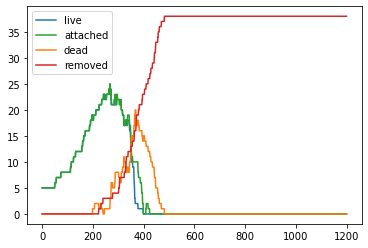

In [35]:
cell_counts = read_summary_file(17, 8, ABM_CFD_DATA_FOLDER)
cell_counts.plot(color=color_dict)

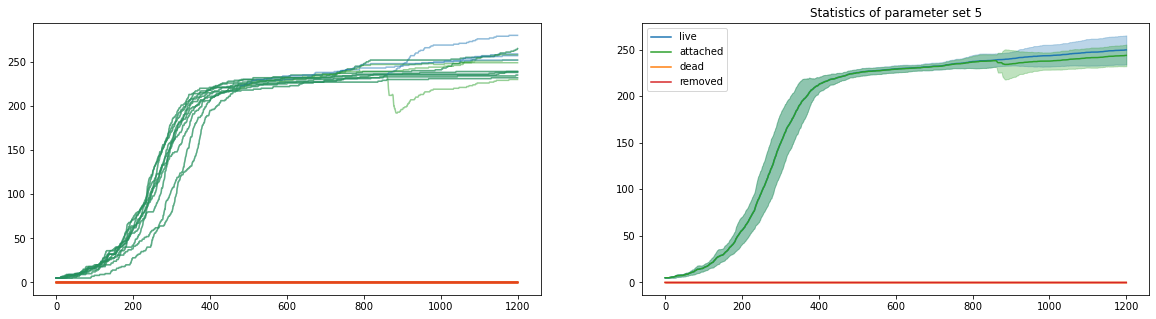

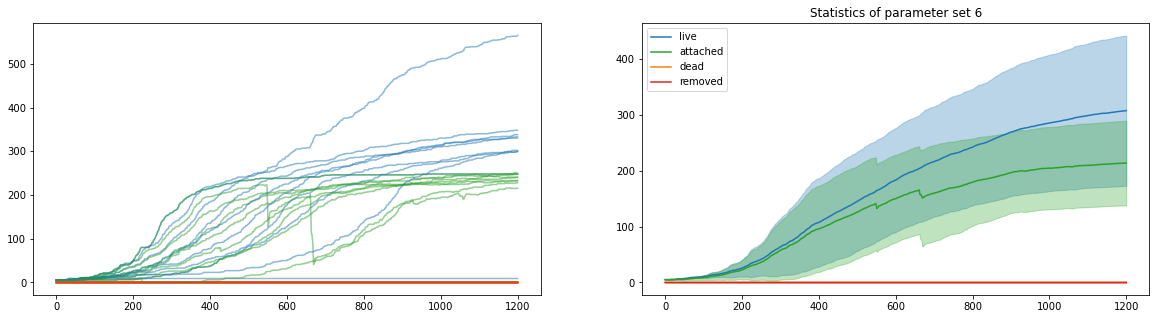

In [36]:
for i in range(5,7):
    fig, ax = plt.subplots(1,2,figsize=(20, 5))
    plot_trials(i, ABM_CFD_DATA_FOLDER, ax=ax[0], legend=False)
    plot_stats(i, ABM_CFD_DATA_FOLDER, ax=ax[1], legend=True)
#     handles, labels = ax[1].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper left')
    



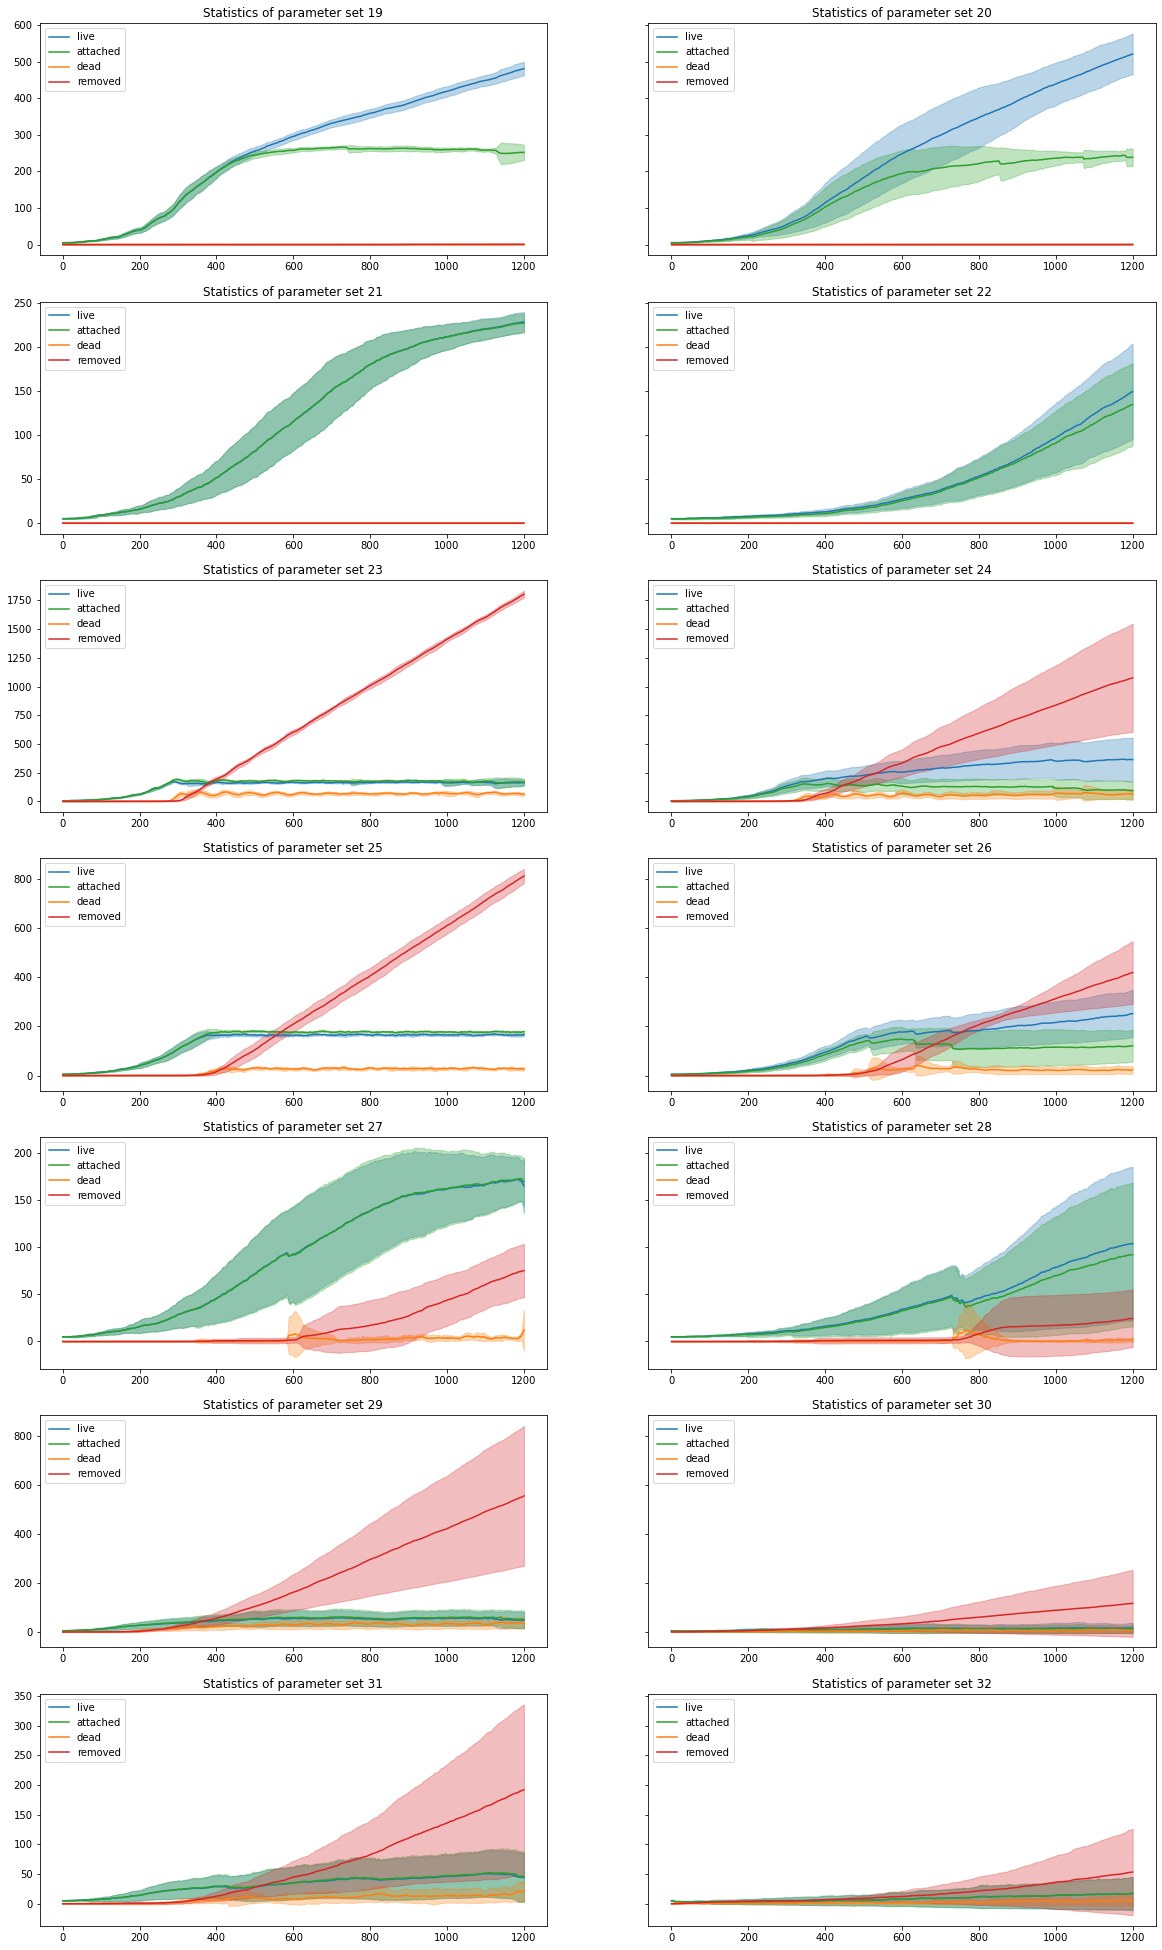

In [37]:
plot_compare_rpms(range(19,33), ABM_CFD_DATA_FOLDER)

In [129]:
from paraview import servermanager as sm
from paraview.vtk.numpy_interface import dataset_adapter as dsa

def read_pvtp_files(pvtp_folder, stop, start=0, interval=1000):
    pvs._DisableFirstRenderCameraReset()
    df_step_dict = {}
    for step in range(start, stop, interval):
        file_name = pvtp_folder / f'agent_{str(step).zfill(6)}.pvtp'
        reader = pvs.XMLPartitionedPolydataReader(FileName = str(file_name))
        vtk_data = sm.Fetch(reader)
        
        object_data = dsa.WrapDataObject(vtk_data)
        data = object_data.GetPointData()

        
        cell_df = pd.DataFrame()
        for i, name in enumerate(data.keys()):
            cell_df[name]=data.GetArray(i)
        pvs.Delete(reader)
        df_step_dict[step] = cell_df
    return df_step_dict
        
def plot_cells_hist(par_id, trial, key, step, model_folder):
    pvtp_folder = model_folder / "output" / f"output_parameter{par_id}_trial{trial}"
    df_step_dict = read_pvtp_files(pvtp_folder, 120000, 0, 2000)
    cell_df = df_step_dict[step]
    cell_df[key].plot.hist(bins=100)
    plt.savefig(FIG_FOLDER / f"cell_hist_{key}_{par_id}_{trial}_{step}.png")

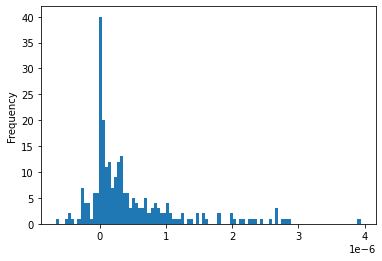

In [130]:
plot_cells_hist(23, 5, "stress", 100000, ABM_CFD_MODEL_FOLDER)